## Time to figure out the SED classes for real. What they do, what they represent, whether $f_\nu$ or $f_\lambda$ is used, etc.

## AB magnitude System  

This magnitude system is defined such that, when monochromatic flux $f_\nu$ is measured in erg sec$^{-1}$ cm$^{-2}$ Hz$^{-1}$,  
$m(AB) = -2.5 \log(f_\nu) - 48.60$  
where the value of the constant is selected to define $m(AB)=V$ for a flat-spectrum source. In this system, an object with constant flux per unit frequency interval has zero color.
It is helpful to bear in mind the identity

$\lambda * f_\lambda = \nu * f_\nu$  
so  
$f_\nu = f_\lambda*(\lambda/\nu) = f_\lambda*\lambda^2/c$.  

[References](https://www.astro.umd.edu/~ssm/ASTR620/mags.html): Oke, J.B. 1974, ApJS, 27, 21

Recall $f_\lambda$ is in units of erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$   
$f_\nu$ is erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$.  

Conversion: $f_\nu = f_\lambda * \lambda^2 / c$.  
Recall $\nu \lambda = c$.

## First the chroma SED class...  

it takes an numpy.interp1d object to generate the $SED(\lambda)$.

```
star_SEDname = "delta450nm.ascii"
w,f = np.genfromtxt(star_SEDname).T
ss = interp1d(w, f)
SED = spec.SED(ss)
```
It assumes the `flux_type` is `'flambda'`, sets `wave_type` to `'nm'` (and `wave_factor` is `1.0`).  
Sets `blue_limit` and `red_limit` to the ranges of `x` (i.e., ranges on $\lambda$).  
Sets `wave_list` to an `np.array` of the input spectrum's `x`s ($\lambda$s).  

Then it sets `_rest_photons = lambda w: (spec(np.array(w) * wave_factor) * w / (h*c))`, i.e.  
rest_photons $= f_\lambda \lambda / \hbar c$ when $x = \lambda$, or...  
rest_photons $= f_\nu / \nu \hbar$ when $x = \nu$.

Code:
```python
   if flux_type == 'flambda':
      # photons/nm = (erg/nm) * (photons/erg)
      #            = spec(w) * 1/(h nu) = spec(w) * lambda / hc
      self._rest_photons = lambda w: (spec(np.array(w) * wave_factor) * w / (h*c))
   elif flux_type == 'fnu':
      # photons/nm = (erg/Hz) * (photons/erg) * (Hz/nm)
      #            = spec(w) * 1/(h nu) * |dnu/dlambda|
      # [Use dnu/dlambda = d(c/lambda)/dlambda = -c/lambda^2 = -nu/lambda]
      #            = spec(w) * 1/(h lambda)
      self._rest_photons = lambda w: (spec(np.array(w) * wave_factor) / (w * h))
```

In [7]:
c = 2.99792458e17  # speed of light in nm/s
h = 6.62606957e-27 # Planck's constant in erg seconds
print c * h

1.98644568327e-09


Chroma SED class seems to do all its work in flux units of photon density.  
It has a `__call__(self, wave)` function which evaluates the SED as a function of wavelength and returns  
`rest_photons(wave)` (see above). For example:
```
wave = np.arange(300.0, 1200.0, 1.0)
photons = SED(wave)
```

#### Using spec.Bandpass from chroma with spec.SED...

We create a bandpass via:
```
fdata = spec.Bandpass(bpDir+'/filter_{}.dat'.format(filter_), red_limit=red_limit, blue_limit=blue_limit)
```
and inside the `Bandpass.__init__(tp)` (`tp` is throughput)...
```
w, t = np.genfromtxt(tp).T
tp = interp1d(w, t)
...
self.func = lambda w: tp(np.array(w) * wave_factor)
```
It also has a `__call__(self, wave)` fucntion which returns throughput as a function of wavelength, setting it to zero outside of `red_limit` and `blue_limit`. So we call it:
```
throughput = fdata(fdata.wave_list)
```
Then we compute DCR via: 
```
SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0)
```

#### OK, how does chroma compute DCR? Let's look...  
It's in the `spec.SED` class...  uses equation (1) from [Plazas and Bernstein (2012)](http://arxiv.org/abs/1204.1346)
to get the 1st moment offset for zenith angle $z_a$, instrumental response function $F(\lambda)$ and source spectrum $S(\lambda)$:
$$ \overline{R}(z_a) = \frac{\int R(\lambda,z_a) F(\lambda) S(\lambda) d\lambda }{\int F(\lambda) S(\lambda) d\lambda } $$  

Here's the code (where `self` is the SED):
```python
   flux = self.calculateFlux(bandpass)
   x = np.union1d(bandpass.wave_list, self.wave_list)
   x = x[(x <= bandpass.red_limit) & (x >= bandpass.blue_limit)]
   R = dcr.get_refraction(x, zenith_angle, **kwargs)
   photons = self(x)
   throughput = bandpass(x)
   Rbar = np.trapz(throughput * photons * R, x) / flux
```
the `spec.SED.calculateFlux(bandpass)` looks like this:
```python
   x = np.union1d(bandpass.wave_list, self.wave_list)
   x = x[(x <= bandpass.red_limit) & (x >= bandpass.blue_limit)]
   flux = np.trapz(bandpass(x) * self(x), x)
```

Note everything above is done in photons since it uses `self(x)`.

## OK, now how is it done in the ACB W13/S14 project code?

Uses `lsst.sims.photUtils.Sed` and `Bandpass`...

First, we do this:
```python
star.readSED_flambda(star_SEDname)
star.flambdaTofnu()
```
Then,
```python
fluxg = fnug * bps['g'].phi
dg1 = getOffset(waveleng, fluxg, zd1)
```
The getOffset function does this:
```python
def getOffset(wavelen, flux, zd):
    photons = flux / wavelen   ## convert flux (still in units of fnu) to photons
    off = refract(wavelen*1.e-3, zd * np.pi / 180.) * 180. / np.pi * 3600. # arcsec
    return np.sum(off * photons) / np.sum(photons)
```
where `refract()` looks a lot like the function that computes $R$ in the chroma code. Note the original S14 `getOffset()` function looked like this:
```python
def getOffset(wavelen, flux, zd):
    off = refract(wavelen*10**-3,  zd * np.pi / 180.) * 180. / np.pi * 3600. # arcsec
    return np.sum(off * flux) / np.sum(flux)
```

### Let's compare the $R$ from `chroma` and the output of `refract()` for a given wavelength and $z_d$.  

They take the same defaults for temperature and pressure.

In [18]:
import numpy as np
import dcr

def refract(wavelength, zd, P=520.0, T=20.0, f=8.0):
    sig_sqrd = 1.0 / (wavelength**2.0)
    xnm1  = 1.e-6 * ( 64.328 + 29498.1 / (146.0 - sig_sqrd) + 255.4 / (41.0 - sig_sqrd) )
    xnm1 *= P * (1.0 + (1.049 - 0.0157 * T) * 1.e-6 * P) / (720.883 * (1.0 + 0.003661 * T))
    xnm1 -= 1.e-6 * f * (0.0624 - 0.000680 * sig_sqrd) / (1.0 + 0.003661 * T)
    xn    = xnm1 + 1.0
    r0    = (xn**2.0 - 1.0) / (2.0 * xn**2.0)
    of    = r0 * np.tan(zd) # radians
    return of

## From S14 code:
P = 520.0
T = 20.0
f = 8.0

## From chroma code:
pressure = 69.328
temperature = 293.15
H2O_pressure = 1.067
#P = pressure * 7.50061683 # kPa -> mmHg
#T = temperature - 273.15 # K -> C
#W = H2O_pressure * 7.50061683 # kPa -> mmHg
#print P, T, W

## Update chroma inputs to make exactly equal to S14 inputs:
pressure = P / 7.50061683
temperature = T + 273.15
H2O_pressure = f / 7.50061683
print pressure, temperature, H2O_pressure

print refract(450*1.e-3, 40. * np.pi/180.0) * 180. / np.pi * 3600.
print dcr.get_refraction(450, 40. * np.pi/180.0, pressure=pressure, temperature=temperature, H2O_pressure=H2O_pressure) * 180. / np.pi * 3600.

69.3276315516 293.15 1.06657894695
32.5603522147
32.5603522147


#### OK, they're the same. 

So now let's look into differences before and after integration over the SED * bandpass...  
First look at `chroma`'s way of doing things:  
First, set things up...


In [19]:
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

1.12043330952e+12
1.12043330952e+12


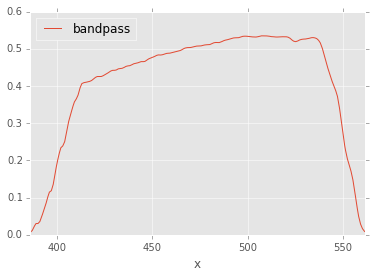

In [57]:
import spec

bpDir = os.environ['LSST_THROUGHPUTS_DEFAULT']
catDir = os.environ['SIMS_SED_LIBRARY_DIR']

SEDname = "delta450nm.ascii"
SED = spec.SED(SEDname) ##.atRedshift(0.5)

import lsst.sims.photUtils.Bandpass as Bandpass
import lsst.sims.photUtils.BandpassDict as bpDict
bps = bpDict.loadTotalBandpassesFromFiles()
##bps, temp = bpDict.loadBandpassesFromFiles()

## Truncate the bandpasses outside their canonical wavelength range
for bp in bps.keys():
    bpobj = bps[bp]
    bpobj.phi[bpobj.phi <= 1.e-4] = 0.
    bpobj.phi[(bpobj.wavelen > bpobj.wavelen_max)] = 0.
    bpobj.phi[(bpobj.wavelen < bpobj.wavelen_min)] = 0.

sbps = {}
for i, filter_ in enumerate('ugrizy'):
    blue_limit = bps[filter_].wavelen[bps[filter_].phi >= 1e-4].min()
    red_limit = bps[filter_].wavelen[bps[filter_].phi >= 1e-4].max()
    #print red_limit, blue_limit
    fdata = spec.Bandpass(bpDir+'/total_{}.dat'.format(filter_), red_limit=red_limit, blue_limit=blue_limit)
    sbps[filter_] = fdata

angles = np.linspace(0,70,71)
angles = np.array([70.])  * np.pi/180.0   ## to radians
filter_ = 'g'

bandpass = sbps[filter_]

flux1 = SED.calculateFlux(bandpass)
print flux1

x = np.union1d(bandpass.wave_list, SED.wave_list)
x = x[(x <= bandpass.red_limit) & (x >= bandpass.blue_limit)]
flux1a = np.trapz(bandpass(x) * SED(x), x)
print flux1a

pd.DataFrame({'x': x, 'bandpass': bandpass(x)}).plot(x='x', y='bandpass')
#pd.DataFrame({'x': x, 'SED': SED(x)}).plot(x='x', y='SED')

#### Compare to flux calc. from S14...

2.18966668524e+13


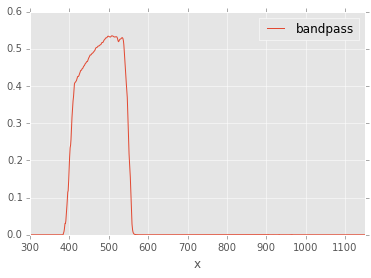

In [59]:
import lsst.sims.photUtils.Sed as Sed

star = Sed()
star.readSED_flambda(SEDname)
star.flambdaTofnu()
bp = bps['g']
#print bp.bandpassname

waveleng, fnug = star.resampleSED(star.wavelen, star.fnu, wavelen_match=bps[filter_].wavelen)
fluxg = fnug * bps['g'].phi

flux2 = np.sum(waveleng * fluxg)
print flux2

pd.DataFrame({'x': bp.wavelen, 'bandpass': bp.sb}).plot(x='x', y='bandpass')
